1) В первую очередь было решено сравнить какая модель справляется с задачей лучше всего (logistic regression, knn, svm, decision trees,random forests) на train. Численные признаки - заполняем средним + используем StandardScaler, категориальные признаки - наиболее часто встречающимся и кодируем OneHotEncoder.

In [2]:
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
test_ids = test_data['id']

train_data = train_data.drop(['Name'], axis=1)
test_data = test_data.drop(['Name'], axis=1)

y = train_data['Depression']
X = train_data.drop(['Depression', 'id'], axis=1)
X_test = test_data.drop(['id'], axis=1)

num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
])

models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVC": SVC(),
    "Decision Tree": DecisionTreeClassifier()
}

print("Cross-Validation Accuracy:")
best_model = None
best_score = 0

for name, clf in models.items():
    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('classifier', clf)
    ])
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
    mean_score = scores.mean()
    print(f"{name:<20}: {mean_score:.5f}")
    
    if mean_score > best_score:
        best_score = mean_score
        best_model = pipeline

best_model.fit(X, y)
final_preds = best_model.predict(X_test)

submission = pd.DataFrame({
    'id': test_ids,
    'Depression': final_preds.astype(int)
})
submission.to_csv('submission.csv', index=False)

Cross-Validation Accuracy:
Logistic Regression : 0.97884
Random Forest       : 0.92648
KNN                 : 0.92225
SVC                 : 0.95875
Decision Tree       : 0.89898


2) Из результатов эксперимента решил выбрать логистическую регрессию как самую перспективную, добавил кодирование бинарных признаков: ответы «Yes» и «No» в столбцах "Have you ever had suicidal thoughts?" и "Family History of Mental Illness" были преобразованы в 1 и 0. Также числовое представление получили: значения в "Sleep Duration" заменены на средние числовые, а уровни "Dietary Habits" закодированы в виде шкалы от 0 до 2.

In [3]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

test_ids = test_data['id']

train_data = train_data.drop(['Name'], axis=1)
test_data = test_data.drop(['Name'], axis=1)

binary_columns = ["Have you ever had suicidal thoughts ?", "Family History of Mental Illness"]
for col in binary_columns:
    train_data[col] = train_data[col].map({'Yes': 1, 'No': 0})
    test_data[col] = test_data[col].map({'Yes': 1, 'No': 0})

sleep_map = {
    "Less than 5 hours": 4.5,
    "5-6 hours": 5.5,
    "7-8 hours": 7.5,
    "More than 8 hours": 8.5
}
train_data['Sleep Duration'] = train_data['Sleep Duration'].map(sleep_map)
test_data['Sleep Duration'] = test_data['Sleep Duration'].map(sleep_map)

dietary_habits = {
    "Unhealthy": 0,
    "Moderate": 1,
    "Healthy": 2
}
train_data['Dietary Habits'] = train_data['Dietary Habits'].map(dietary_habits)
test_data['Dietary Habits'] = test_data['Dietary Habits'].map(dietary_habits)

y = train_data['Depression']
X = train_data.drop(['Depression', 'id'], axis=1)
X_test = test_data.drop(['id'], axis=1)

num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

model_pipeline.fit(X, y)

predictions = model_pipeline.predict(X_test)

submission = pd.DataFrame({'id': test_ids, 'Depression': predictions})
submission.to_csv('submission.csv', index=False)

print("Submission Label Distribution:")
print(submission["Depression"].value_counts())

Submission Label Distribution:
Depression
0    549
1    116
Name: count, dtype: int64


3) Кодирование признаков не дало никакого результата(сделало только хуже), перешел к другому варианту: добавление параметров логистической регрессии и удаление неинформативных столбцов. Параметр C в логистической регрессии управляет степенью регуляризации: при малом C сильная регуляризация снижает риск переобучения, но может привести к недообучению, а при большом C модель становится более гибкой, но повышается риск переобучения. Данный код привел к очень неплохому результату 0.99502 и предполагалось что для public было найдено неверно только 1 число.  

In [4]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

test_ids = test_data['id']

columns_to_drop = ['Name', 'City', 'Profession', 'Degree'] # Gender
train_data = train_data.drop(columns=columns_to_drop, axis=1)
test_data = test_data.drop(columns=columns_to_drop, axis=1)

y = train_data['Depression']
X = train_data.drop(['Depression', 'id'], axis=1)
X_test = test_data.drop(['id'], axis=1)

num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=3000))
])

param_grid = {
    'classifier__C': [0.1, 1, 5, 10, 20, 25, 50],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(model_pipeline, param_grid, cv=cv, n_jobs=-1)

grid_search.fit(X, y)

predictions = grid_search.predict(X_test)

submission = pd.DataFrame({'id': test_ids, 'Depression': predictions})
submission.to_csv('submission_best.csv', index=False)

print("Submission Label Distribution:")
print(submission["Depression"].value_counts())

print(f"Score on Validation Set: {grid_search.best_score_}")

Submission Label Distribution:
Depression
0    548
1    117
Name: count, dtype: int64
Score on Validation Set: 0.994182686267119


4) Оставшиеся коды считаю излишними, но хотелось добить до 1.00000. Из графиков было видно, что Age - наиболее важнейший признакю Решил применять логарифмирование к одному признаку - Age (т.к остальные признаки там итак небольшие). Такое предсказание привело к отличию от прошлого результата в 6 строках.

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
test_ids = test_data['id']

columns_to_drop = ['Name', 'City', 'Profession', 'Degree']
train_data = train_data.drop(columns=columns_to_drop, axis=1)
test_data = test_data.drop(columns=columns_to_drop, axis=1)

y = train_data['Depression']
X = train_data.drop(['Depression', 'id'], axis=1)
X_test = test_data.drop(['id'], axis=1)

num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

num_transformers = []
for i, col in enumerate(num_features):
    if col == 'Age':
        transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('log', FunctionTransformer(np.log1p, feature_names_out='one-to-one')),
            ('scaler', StandardScaler())
        ])
    else:
        transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
    num_transformers.append((f'num_{col}', transformer, [col]))

cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=num_transformers + [('cat', cat_pipeline, cat_features)]
)

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=3000))
])

param_grid = {
    'classifier__C': [0.1, 1, 5, 10, 20, 25, 50],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(model_pipeline, param_grid, cv=cv, n_jobs=-1)
grid_search.fit(X, y)

predictions = grid_search.predict(X_test)

submission = pd.DataFrame({'id': test_ids, 'Depression': predictions})
submission.to_csv('submission.csv', index=False)

print("Submission Label Distribution:")
print(submission["Depression"].value_counts())

print(f"Score on Validation Set: {grid_search.best_score_:.5f}")

Submission Label Distribution:
Depression
0    550
1    115
Name: count, dtype: int64
Score on Validation Set: 0.98625


5) Данная часть по большей части является объединением 3 и 4, но теперь рассматривается разница 6 столбцов о которой говорилось раньше - для них возраст заменяется на 30 (что-то среднее между возростами) и снова предсказывается. Итоговый результат - public предсказан на     1.00000

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
test_ids = test_data['id']

columns_to_drop = ['Name', 'City', 'Profession', 'Degree']
train_data = train_data.drop(columns=columns_to_drop, axis=1)
test_data = test_data.drop(columns=columns_to_drop, axis=1)

y = train_data['Depression']
X = train_data.drop(['Depression', 'id'], axis=1)
X_test = test_data.drop(['id'], axis=1)

num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

num_transformers_no_log = []
for i, col in enumerate(num_features):
    if col == 'Age':
        transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
    else:
        transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
    num_transformers_no_log.append((f'num_{col}', transformer, [col]))

num_transformers_log = []
for i, col in enumerate(num_features):
    if col == 'Age':
        transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('log', FunctionTransformer(np.log1p, feature_names_out='one-to-one')),
            ('scaler', StandardScaler())
        ])
    else:
        transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
    num_transformers_log.append((f'num_{col}', transformer, [col]))

cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_no_log = ColumnTransformer(
    transformers=num_transformers_no_log + [('cat', cat_pipeline, cat_features)]
)

preprocessor_log = ColumnTransformer(
    transformers=num_transformers_log + [('cat', cat_pipeline, cat_features)]
)

model_pipeline_no_log = Pipeline(steps=[
    ('preprocessor', preprocessor_no_log),
    ('classifier', LogisticRegression(random_state=42, max_iter=3000))
])

model_pipeline_log = Pipeline(steps=[
    ('preprocessor', preprocessor_log),
    ('classifier', LogisticRegression(random_state=42, max_iter=3000))
])

param_grid = {
    'classifier__C': [0.1, 1, 5, 10, 20, 25, 50],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Обучаем модель без логарифмирования
grid_search_no_log = GridSearchCV(model_pipeline_no_log, param_grid, cv=cv, n_jobs=-1)
grid_search_no_log.fit(X, y)

# Обучаем модель с логарифмированием
grid_search_log = GridSearchCV(model_pipeline_log, param_grid, cv=cv, n_jobs=-1)
grid_search_log.fit(X, y)

# Делаем предсказания для обеих моделей
predictions_no_log = grid_search_no_log.predict(X_test)
predictions_log = grid_search_log.predict(X_test)

# Сравниваем предсказания
differences = predictions_no_log != predictions_log

# Индексы, где предсказания различаются
different_indices = np.where(differences)[0]

print("Предсказания до пересчета:")
for idx in different_indices:
    print(f"{idx + 1}, No_log: {predictions_no_log[idx]}, Log: {predictions_log[idx]}")

X_test_modified = X_test.copy()
X_test_modified.loc[different_indices, 'Age'] = 30

predictions_no_log_modified = grid_search_no_log.predict(X_test_modified)

print("\nПредсказания после пересчета (с заменой 'Age' на 30):")
for idx in different_indices:
    print(f"{idx + 1}, New: {predictions_no_log_modified[idx]}")

predictions_no_log[differences] = predictions_no_log_modified[differences]

submission_no_log_updated = pd.DataFrame({'id': test_ids, 'Depression': predictions_no_log})
submission_no_log_updated.to_csv('submission_no_log_updated.csv', index=False)

print("\nИтоговый файл: submission_no_log_updated.csv")

submission_no_log = pd.DataFrame({'id': test_ids, 'Depression': predictions_no_log})
#submission_no_log.to_csv('submission_no_log.csv', index=False)

submission_log = pd.DataFrame({'id': test_ids, 'Depression': predictions_log})
#submission_log.to_csv('submission_log.csv', index=False)

Предсказания до пересчета:
5, No_log: 1, Log: 0
159, No_log: 0, Log: 1
295, No_log: 1, Log: 0
342, No_log: 0, Log: 1
491, No_log: 1, Log: 0
582, No_log: 1, Log: 0

Предсказания после пересчета (с заменой 'Age' на 30):
5, New: 1
159, New: 0
295, New: 1
342, New: 1
491, New: 1
582, New: 1

Итоговый файл: submission_no_log_updated.csv


6) Просто небольшой код для сравнения как изменился submission

In [7]:
import pandas as pd

sub1 = pd.read_csv('submission_best.csv')
sub2 = pd.read_csv('submission_no_log_updated.csv')

sub1 = sub1.sort_values('id').reset_index(drop=True)
sub2 = sub2.sort_values('id').reset_index(drop=True)

comparison = pd.DataFrame({
    'id': sub1['id'],
    'First': sub1['Depression'],
    'Second': sub2['Depression']
})

diffs = comparison[comparison['First'] != comparison['Second']]
print(f'Найдено различий: {len(diffs)}')
print(diffs.to_string(index=False))

Найдено различий: 1
 id  First  Second
342      0       1


7) Целью этого кода является анализ данных. Он включает в себя визуализацию распределений признаков, исследование их корреляций, оценку качества модели с помощью ROC-кривой и AUC, а также определение важности признаков для улучшения модели логистической регрессии.

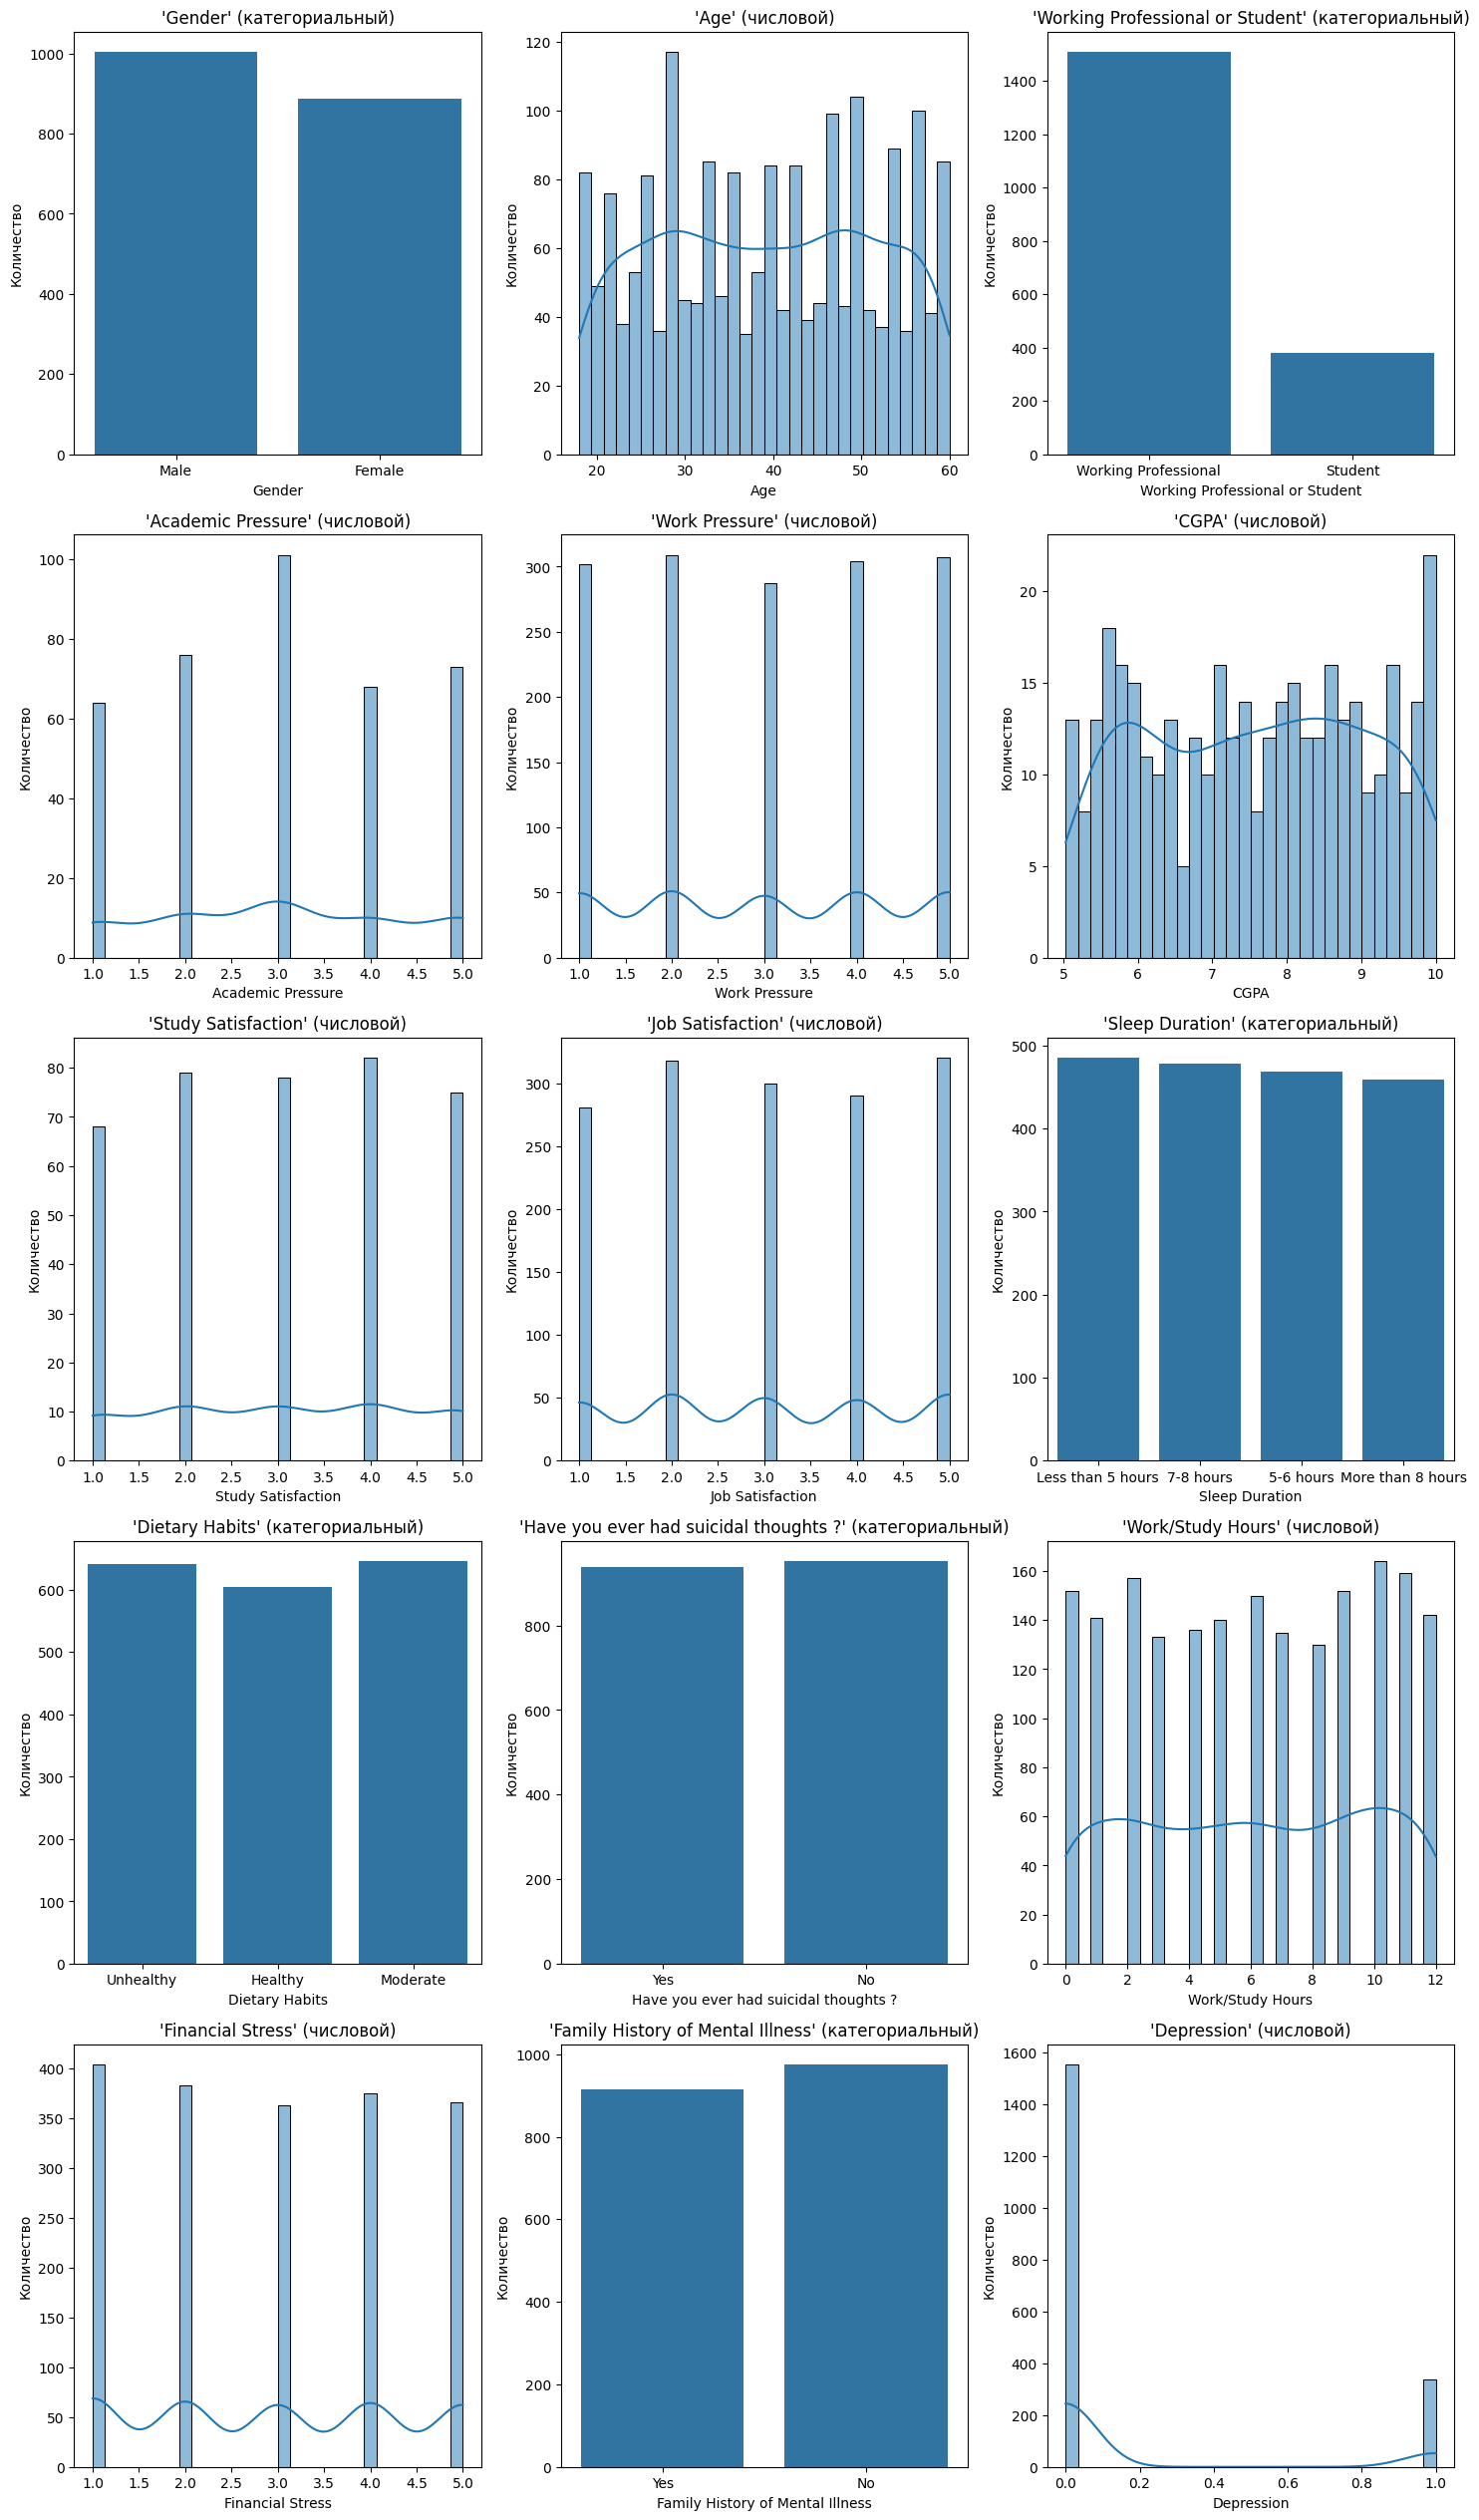

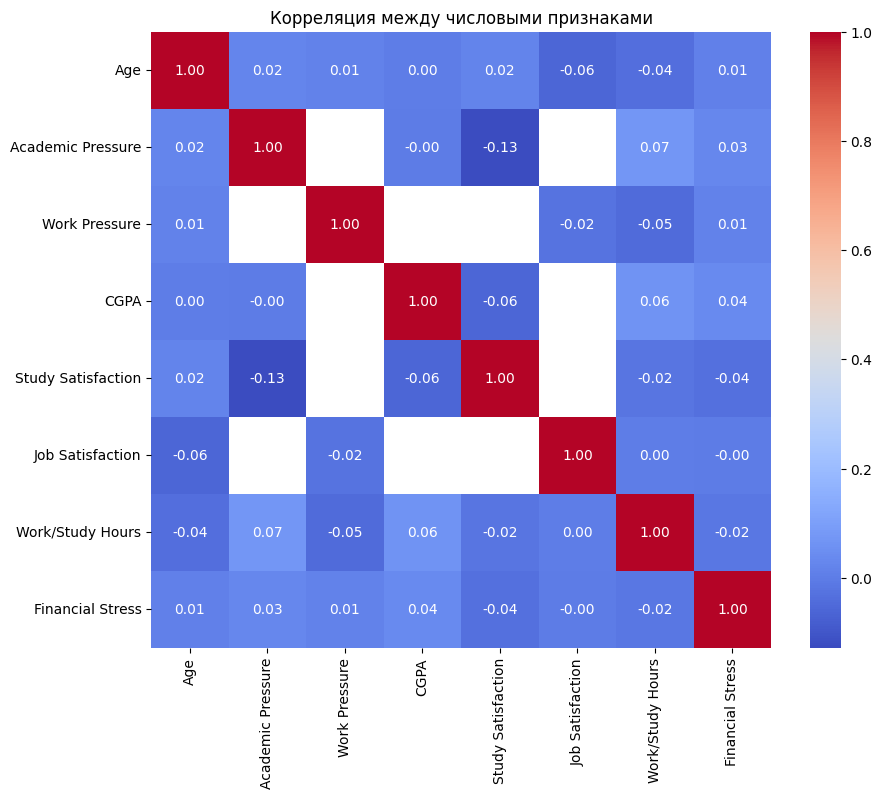

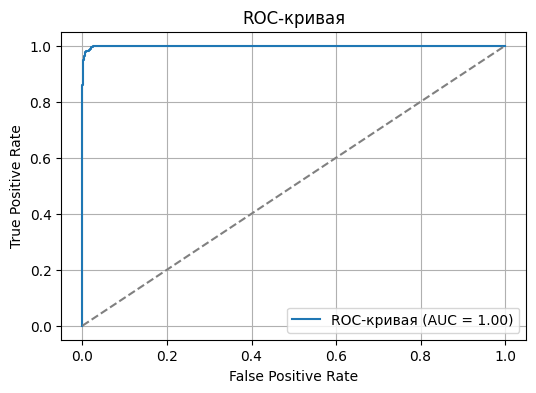

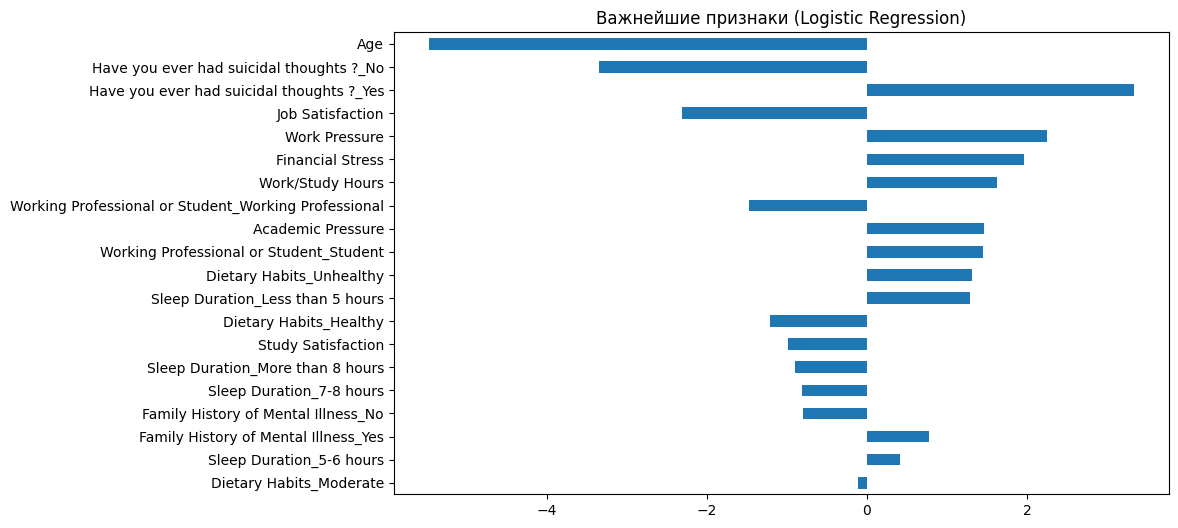

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

train_data = pd.read_csv('train.csv')

columns_to_drop = ['Name', 'City', 'Profession', 'id', 'Degree']
train_data = train_data.drop(columns=columns_to_drop, axis=1)

X = train_data.drop(columns=['Depression'])
y = train_data['Depression']

num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

# 1. Распределение классов
X_vis = X.copy()
X_vis['Depression'] = y

num_plots = len(X_vis.columns)
fig, axes = plt.subplots(nrows=(num_plots // 3) + 1, ncols=3, figsize=(15, 5 * (num_plots // 3 + 1)))
axes = axes.flatten()

for i, feature in enumerate(X_vis.columns):
    ax = axes[i]
    if X_vis[feature].dtype in ['int64', 'float64']:
        sns.histplot(X_vis[feature], kde=True, bins=30, ax=ax)
        ax.set_title(f"'{feature}' (числовой)")
    else:
        sns.countplot(x=X_vis[feature], ax=ax)
        ax.set_title(f"'{feature}' (категориальный)")
    
    ax.set_xlabel(feature)
    ax.set_ylabel("Количество")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# 2. Корреляция числовых признаков
plt.figure(figsize=(10, 8))
corr_matrix = X[num_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляция между числовыми признаками")
plt.show()

# 3. ROC-кривая
num_pipeline = Pipeline(steps=[ 
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline(steps=[ 
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[ 
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

model_pipeline = Pipeline(steps=[ 
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

y_proba = cross_val_predict(model_pipeline, X, y, cv=5, method="predict_proba")[:, 1]

if len(np.unique(y)) == 2:
    fpr, tpr, _ = roc_curve(y, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC-кривая (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-кривая")
    plt.legend()
    plt.grid()
    plt.show()

# 4. Важность признаков (Logistic Regression)
model_pipeline.fit(X, y)

best_model = model_pipeline
feature_names_num = num_features
feature_names_cat = best_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(cat_features)

feature_names_all = np.concatenate([feature_names_num, feature_names_cat])

coefficients = best_model.named_steps['classifier'].coef_[0]
feature_importance = pd.Series(coefficients, index=feature_names_all).sort_values(key=abs, ascending=False)

plt.figure(figsize=(10, 6))
feature_importance[:20].plot(kind='barh')
plt.title("Важнейшие признаки (Logistic Regression)")
plt.gca().invert_yaxis()
plt.show()